In [1]:
# FUNCTIONS
import numpy as np
import matplotlib.pyplot as plt
import math

def act_func(x, n_HPC):
    result = np.empty_like(x)
    result[:n_HPC] = np.tanh(x[:n_HPC])
    result[n_HPC:] = np.tanh(0.5 * x[n_HPC:])     # from 0.46*x
    return result


def hopfield(x, W, I, n_HPC):
    dxdt = -x + act_func(W @ x + I, n_HPC)
    return dxdt


def hebbian(W, r, learn_rate, decay_rate):
    
    firing_rates = np.copy(r)
    
    # Gating of plasticity avoids noise to be encoded.
    # This is important during the sleep phase, when the network loops over many cycles 
    # and where the 'noisy connections' can become amplified with each cycle.
    
    for j,rate in enumerate(firing_rates):
        if abs(firing_rates[j])<0.4:
            firing_rates[j]=0

    dw = (learn_rate*(1 - W)*np.outer(firing_rates, firing_rates) - decay_rate*W)/len(firing_rates)
    
    return dw

def generate_pattern(Number_units, number_engram_cells ):
    pattern = np.zeros(Number_units)
    pattern[:number_engram_cells] = np.random.choice([-1, 1], size=number_engram_cells).astype(int)
    return pattern


# Function to create connectivity plots
def plot_weights( weights, title, filename, ax=None, ylabel=True):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        ax = ax

    
    # Create a mask for the weights matrix
    mask = np.where(np.abs(weights) < 0.07, 1, 0)  # set entries smaller than 0.07 to 1
      
    color_map = ax.imshow(np.ma.masked_array(weights, mask=mask), extent=[0, weights.shape[0], 0, weights.shape[1]], 
                          vmin=-1, vmax=1, aspect='auto', cmap=cmap)
    
#    colorbar = plt.colorbar(color_map, ax=ax)
#    colorbar.set_ticks([-1, 0, 1])
#    colorbar.set_label('Syn. strength', fontsize=20, rotation=270, labelpad=20)
    ax.set_xlabel('(Pre) Neuron #', fontsize=25)
    if ylabel==True:
        ax.set_ylabel('(Post) Neuron #', fontsize=25)
        ytick_positions = np.arange(0, weights.shape[1]+1, weights.shape[1]/2)
        ytick_labels = np.arange(int(weights.shape[1]), -1, int(-weights.shape[1]/2))
        ax.set_yticks(ytick_positions)
        ax.set_yticklabels(ytick_labels, fontsize=18)

        
    elif ylabel==False:
        ax.set_yticks([])
    ax.set_title(title, fontsize=20, pad=15)

    xtick_positions = np.arange(0, weights.shape[0]+1, weights.shape[0]/2) 
    xtick_labels = np.arange(0, weights.shape[0] + 1, int(weights.shape[0] / 2))
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, fontsize=18)
    


    #plt.savefig(filename, dpi=params['savefig.dpi'], transparent=params['savefig.transparent'], bbox_inches='tight')


def plot_input(state, Input, Input_name, n_total, cmap, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    else:
        ax = ax

    for i in range(n_total):
        ax.add_patch(plt.Rectangle((i-0.5, -0.5), 1, 1, fill=False, edgecolor='black'))
    input_cmap = ax.imshow(Input, cmap=cmap, vmin=-1, vmax=1)
    ax.set_title(f'{Input_name}', fontsize=25, pad=15)  # Set the title and adjust the pad value for spacing
    ax.set_yticks([])  # Remove y ticks
    ax.set_xticks([])
    
    #plt.savefig(f'Input_{state}.png', bbox_inches='tight', dpi=600, transparent=True)


def plot_RNN(region, state, neuron_positions, r, cmap, circle_radius=0.05, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        ax = ax

    # Draw neurons as circles
    for neuron in range(len(neuron_positions)):
        x, y = neuron_positions[neuron]
        circle = plt.Circle((x, y), radius=circle_radius, edgecolor='black', facecolor='white', linewidth=1)
        ax.add_patch(circle)
        
    # Create a masked array for r
    mask = np.abs(r[0]) < 0.2
    r_masked = np.ma.masked_array(r[0], mask)

    # Use plt.scatter with the masked array to plot the colored points
    sc = ax.scatter([pos[0] for pos in neuron_positions], [pos[1] for pos in neuron_positions],
                 c=r_masked, cmap=cmap, s=150, vmin=-1, vmax=1)
    sc.set_facecolor("white")  # set the color of the masked points to white        
    
    # Add colorbar to show the mapping of the third variable (r_final_PFC) to colors
#    colorbar = plt.colorbar(sc, ax=ax)
#    colorbar.set_label('Activity, $x$', fontsize=20, rotation=270, labelpad=20)
#    colorbar.set_ticks([-1, 0, 1])

    # Hide axis lines, ticks, and labels
    ax.axis('off')

    # Set aspect ratio to equal so circles are not distorted
    ax.set_aspect('equal')

    ax.set_title(f'{region}', fontsize=20, pad=10, loc='left')
    # Save the plot
    #plt.savefig(f'RNN_{region}_{state}.png')

# for my computer
#def bar_activity(x,r, ax=None, ylabel=True):
    # Bar graph with states for HPC
#    ax.bar(x, r.flatten(), width=1, edgecolor='black', color='grey')
#    ax.set_xlabel('Neuron #', fontsize=25)
#    if ylabel==True:
#        ax.set_ylabel('Act., $x$', fontsize=25)
#        ax.set_yticks([-1, 1], fontsize=18)
#    else:
#        ax.set_yticks([], fontsize=18)
#    ax.set_ylim([-1.2,1.2])
#    ax.spines['top'].set_visible(False)
#    ax.spines['right'].set_visible(False)
#    ax.spines['left'].set_visible(False)

# for lab computer
def bar_activity(x, r, ax=None, ylabel=True):
    # Bar graph with states for HPC
    ax.bar(x, r.flatten(), width=1, edgecolor='black', color='grey')
    ax.set_xlabel('Neuron #', fontsize=25)
    if ylabel:
        ax.set_ylabel('Act., $x$', fontsize=25)
        ax.set_yticks([-1, 1])
        ax.set_yticklabels([-1, 1], fontsize=18)
    else:
        ax.set_yticks([])
    ax.set_ylim([-1.2, 1.2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    
    
    
def get_overlap_array(P, overlap_fraction):  

    #print(pattern)
    indices_non_zero = np.where(np.logical_or(P == -1, P == 1))[0]
    num_non_zero = len(indices_non_zero)
    
    indices_zero = np.where(P == 0)[0]
    num_zero = len(indices_zero)

    num_non_overlap = int(round(num_non_zero * (1-overlap_fraction)))  # Compute number of matching entries
    
    # Initialize overlap array I equal to P
    I = np.copy(P)
    
    # Randomly select indices for non-matching entries
    non_overlap_indices1 =  np.random.choice(indices_non_zero, num_non_overlap, replace=False)
    non_overlap_indices2 =  np.random.choice(indices_zero, num_non_overlap, replace=False)

    # Change non-matching entries in I to be zero or 1
    I[non_overlap_indices1] = 0
    I[non_overlap_indices2] =  np.random.choice([-1, 1], size=num_non_overlap)
    
    return I


def get_recall_input(P, number_act_units):  

    #print(pattern)
    indices_non_zero = np.where(np.logical_or(P == -1, P == 1))[0]
    
    # Randomly select indices for non-matching entries
    non_overlap_entries = np.random.choice(indices_non_zero, size=(10-number_act_units), replace=False)
        
    # Initialize overlap array I equal to P
    I = np.copy(P)
    
    # Change non-matching entries in I to be zero or 1
    I[non_overlap_entries] = 0
    
    return I

import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
colors = ['#273B86', '#2A4090', '#2D449A', '#3149A4', '#344EAE', '#3752B8', '#3A57C2', '#3E5CCD', '#4160D7', '#4660D8', '#5062D9', '#6065D9', '#6A71E1', '#7478E3', '#888BEF', '#9BA3EB', '#BBC1F4', '#DBDFFD', '#EDEFFE', '#FFFFFF',
'#F9F9EE', '#F6EEB7', '#F3E280', '#EDD62E', '#ECCB12', '#EEC711', '#EFC422', '#F0C01B', '#F1BC31', '#E7AE2E', '#DE9A2B', '#D98C18', '#D4821D', '#CB7926', '#C26D24', '#B95821', '#B14E1E', '#AA461D', '#A6371C']

cmap = mcolors.ListedColormap(colors)

neuron_positions = [
    [0.4, 0.9], [0.15, 0.65], [0.6, 0.9], [0.07, 0.5], [0.3, 0.6],[0.21, 0.9], [0.1, 0.8], [0.3, 0.8], [0.5, 0.8], [0.4, 0.72],
    [0.38, 0.45], [0.15, 0.15], [0.85, 0.85], [0.7, 0.4], [0.3, 0.1],[0.21, 0.4], [0.1, 0.3], [0.3, 0.3], [0.55, 0.35], [0.4, 0.22],
    [0.85, 0.35], [0.6, 0.2], [0.8, 0.2], [0.5, 0.5], [0.7, 0.1],[0.61, 0.65], [0.8, 0.6], [0.9, 0.7], [0.5, 0.1], [0.7, 0.75]
]

### Encoding and consolidation of a memory in a naive neural network (Figure 1)

In [2]:
%matplotlib inline

#### Pattern A - Awake stage

In [3]:
n_HPC = 30
n_PFC = 30
n_total = n_HPC + n_PFC

learn_HPC = 0.45
decay_HPC = 0.55
learn_PFC = 0.06  # or 0.06
decay_PFC = 0
dt=0.01

# Connectivity matrix
weights = np.zeros((n_total, n_total))
v1 = [i for i in range(n_HPC, n_total)]
v2 = [i for i in range(0, n_HPC)]
weights[v2,v1]=-1
weights[v1,v2]=0.5

r =  np.zeros(n_total)
r_total = []

#P = generate_pattern(n_HPC, 5) # input pattern
P = np.array([-1, 1, -1,  1, -1,-1, 1, -1,  1, -1])
P_zeros = np.zeros(20)
P = np.concatenate((P, P_zeros))
Ext_input = P.reshape(1,n_HPC)
pattern = np.copy(P)
print('pattern to store:', P)
P=np.concatenate((P,P))

i=0

while True:  
    
    weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
    weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)  
    
    r_new = r + dt*hopfield(r, weights, P, n_HPC)
    
    r_total.append(r)
    
    if i>7600:
        print(r_new)
        break
        
    i+=1
    r = r_new
    
r_total = list(zip(*r_total))

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)

trained_weights_awake1 = np.copy(weights)


pattern to store: [-1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.99997087  0.99999372 -0.99997087  0.99999372 -0.99997087 -0.99997087
  0.99999372 -0.99997087  0.99999372 -0.99997087  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.76038693  0.76186116 -0.76038693  0.76186116 -0.76038693 -0.76038693
  0.76186116 -0.76038693  0.76186116 -0.76038693  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


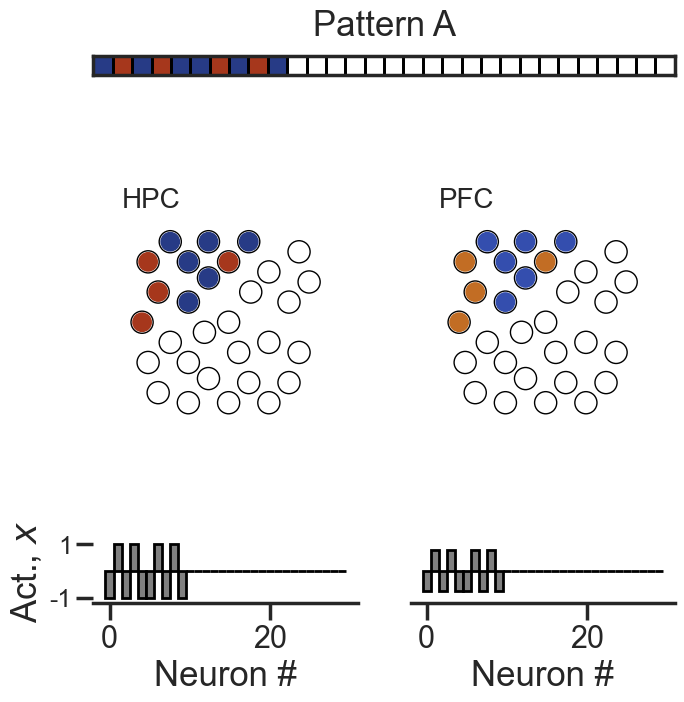

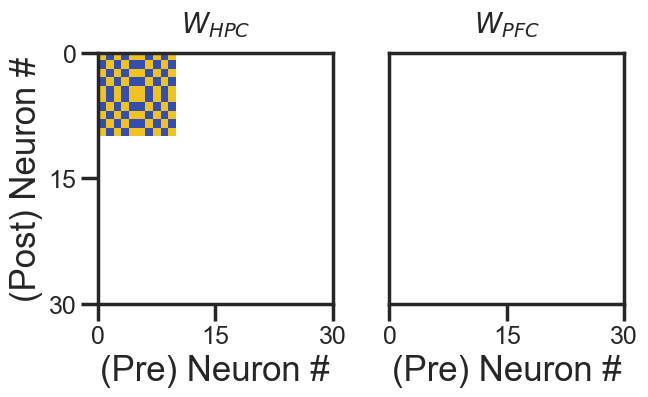

In [4]:
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(style='white')
sns.set_style('ticks')
sns.set_context('poster')


# Figure 1 a)
fig = plt.figure(figsize=(7.5, 7.5))
grid = plt.GridSpec(3, 2, hspace=1, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input('awake1', Ext_input, 'Pattern A', n_total, cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', 'awake1', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', 'awake1', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)


# Adjust layout and save the figure
plt.savefig('Figure1_a.png', dpi=600, transparent=True)
plt.show

# Figure 1 b)
fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure1_b.png', dpi=600, transparent=True)
plt.show()


#### Pattern A - Sleeping stage

0


C:\Users\iguerrei\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)
C:\Users\iguerrei\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


1
2
3
4
5
6


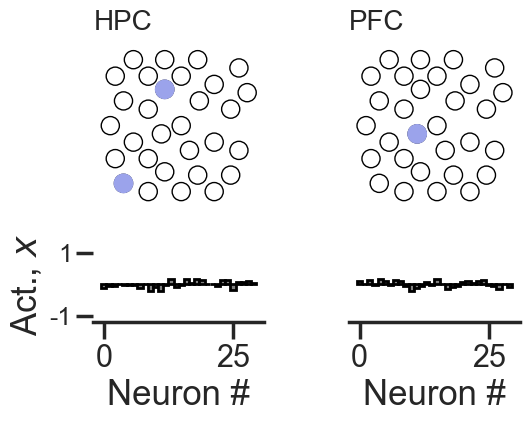

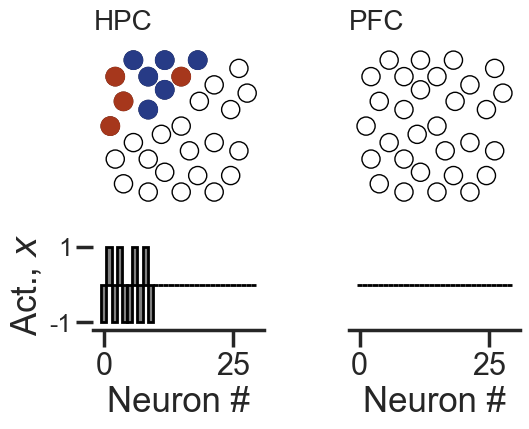

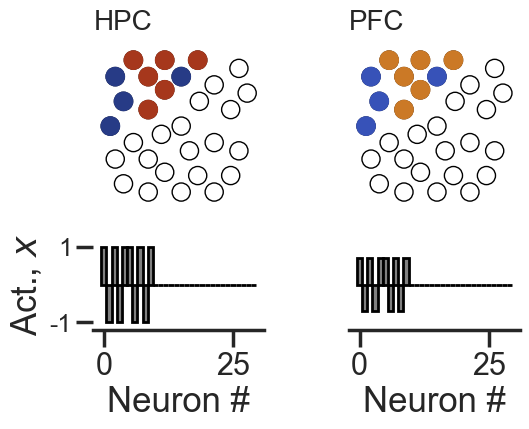

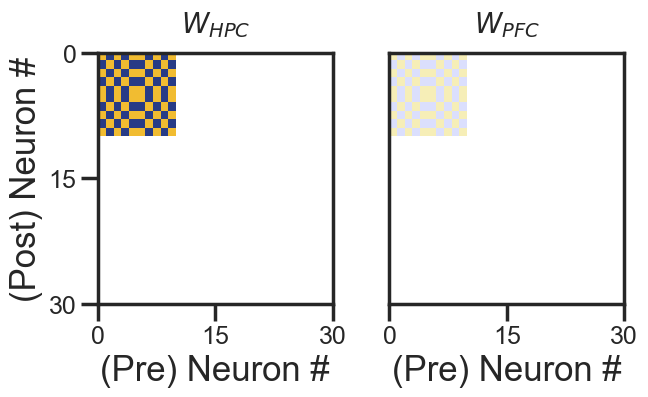

In [5]:
weights = np.copy(trained_weights_awake1)
#r =  np.random.normal(loc=0, scale=0.2, size=n_total)
v1 = [i for i in range(n_HPC, n_total)]
v2 = [i for i in range(0, n_HPC)]
weights[v2,v1]=0 # HPC projects to PFC with one-to-one connections. it works if it is -1 too.

for j in range(7):

    print(j)

    r =  np.random.normal(loc=0, scale=0.1, size=n_total)
    
    if j==0:
        r_init_HPC = r[:n_HPC].reshape(1,n_HPC)
        r_init_PFC = r[n_HPC:].reshape(1,n_HPC)
        
        # Figure 1 c1)
        fig = plt.figure(figsize=(5.5, 5))
        grid = plt.GridSpec(2, 2, hspace=-0.3, wspace=0.5, width_ratios=[1, 1], height_ratios=[1, 0.2])

        ax_rnn_hpc = fig.add_subplot(grid[0, 0])
        plot_RNN('HPC', 'sleep1_phase1', neuron_positions, r_init_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

        ax_rnn_pfc = fig.add_subplot(grid[0, 1])
        plot_RNN('PFC', 'sleep1_phase1', neuron_positions, r_init_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)
        
        # Bar graph with states for HPC
        ax_bar_hpc = fig.add_subplot(grid[1, 0])
        bar_activity(x,r_init_HPC, ax=ax_bar_hpc, ylabel=True)

        # Bar graph with states for PFC
        ax_bar_pfc = fig.add_subplot(grid[1, 1])
        bar_activity(x,r_init_PFC, ax=ax_bar_pfc, ylabel=False)

        plt.savefig('Figure1_c1.png', dpi=600, transparent=True, bbox_inches='tight')

    
    r_total = []

    i=0

    while True:  
    
    # in a first sleep phase, the HPC and PFC are uncoupled. 
    # During this phase, the HPC, starting from a noisy state, converges to its attractor and replays activity experienced during awake.
    # When it reaches the attractor state, the activity of the network is high (in particular of the engram cells)
    # at this stage, we couple the 2 regions (unidirectionally). 
    # adding inhibitory connections from PFC is not necessary but then won't change the result either. 
        if j==0:
            if i==9000:
                r_HPC = r[:n_HPC].reshape(1,n_HPC)
                r_PFC = r[n_HPC:].reshape(1,n_HPC)
        
                # Figure 1 c1)
                fig = plt.figure(figsize=(5.5, 5))
                grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

                ax_rnn_hpc = fig.add_subplot(grid[0, 0])
                plot_RNN('HPC', 'sleep1_phase1', neuron_positions, r_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

                ax_rnn_pfc = fig.add_subplot(grid[0, 1])
                plot_RNN('PFC', 'sleep1_phase1', neuron_positions, r_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

                # Bar graph with states for HPC
                ax_bar_hpc = fig.add_subplot(grid[1, 0])
                bar_activity(x,r_HPC, ax=ax_bar_hpc, ylabel=True)

                # Bar graph with states for PFC
                ax_bar_pfc = fig.add_subplot(grid[1, 1])
                bar_activity(x,r_PFC, ax=ax_bar_pfc, ylabel=False)

                # Adjust layout and save the figure
                plt.savefig('Figure1_c2.png', dpi=600, transparent=True, bbox_inches='tight')
        
    
        if i>9000:
            weights[v1,v2]=1
            weights[v2,v1]=-1
        else:
            weights[v1,v2]=0
            weights[v2,v1]=0
    
    
        weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC) 
        weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)
    
        r_new = r + dt*hopfield(r, weights, 0, n_HPC)
    
        r_total.append(r)
    

        if i>9900: # from 3100 
            #print(r_new)
            break
        
        i+=1
        r = r_new
    
r_total = list(zip(*r_total))

trained_weights_sleep1 = np.copy(weights)

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


# Plots 
# Figure 1 c3)
fig = plt.figure(figsize=(5.5, 5))
grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

ax_rnn_hpc = fig.add_subplot(grid[0, 0])
plot_RNN('HPC', 'sleep1_phase2', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[0, 1])
plot_RNN('PFC', 'sleep1_phase2', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
ax_bar_hpc = fig.add_subplot(grid[1, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)

# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[1, 1])
bar_activity(x,r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
plt.savefig('Figure1_c3.png', dpi=600, transparent=True,  bbox_inches='tight')
plt.show


# Figure 1 d)
fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure1_d.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()



PFC_trained_weights_sleep1 = np.copy(weights[n_HPC:,n_HPC:])

### Recall pattern A (Figure S1)

'Argument' for recall: activity of all units of engram to be >=0.1

C:\Users\iguerrei\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


(30,)
[ 0.          0.          0.          0.76159416 -0.76159416 -0.76159416
  0.76159416 -0.76159416  0.76159416 -0.76159416  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.2822705   0.2877057  -0.2822705   0.66183007 -0.65849254 -0.65849254
  0.66183007 -0.65849254  0.66183007 -0.65849254  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


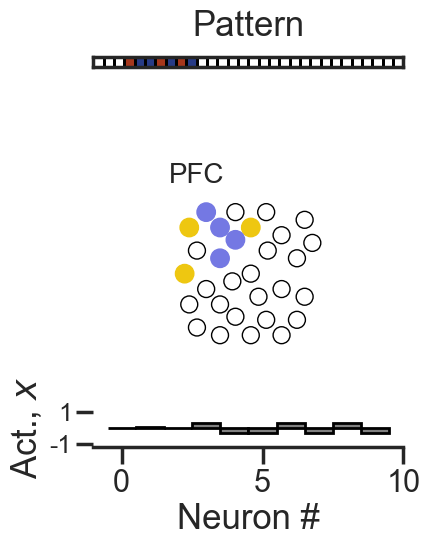

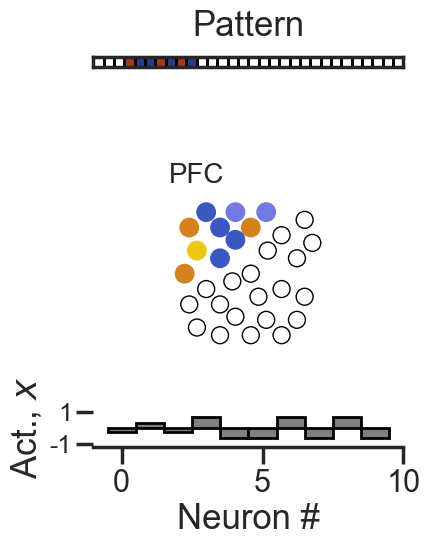

In [6]:
def plot_fr(r_total, targeted_neurons):
    abs_r_total = np.abs(r_total)
    
    fig, ax = plt.subplots(10, 1, figsize=(4,15))
    
    for j,n in enumerate(targeted_neurons):
        iterations = np.arange(len(r_total[n]))
    
        ax[j].spines['top'].set_visible(False)
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].xaxis.tick_bottom()
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].set_ylim([-0.2, 1.2])
        ax[j].plot(abs_r_total[n+30][:], color='#335781', linewidth=4, label='PFC')
        ax[j].fill_between(iterations, abs_r_total[n+30][:], 0, alpha=0.2, color='#335781')
#        ax[j].plot(abs_r_total[n][:], color='#9FBB55', linewidth=4, label='HPC')
#        ax[j].fill_between(iterations, abs_r_total[n][:], 0, alpha=0.2, color='#9FBB55')
#        if j==5:
#            ax[j].set_ylabel(f'Activity of neurons targeted by input B, $|x_i|$', fontsize=18, fontweight='bold')
#        if j==0:
#            ax[j].set_title(f'Overlap 90$\%$', fontsize=18)
        if j!=9:
            ax[j].spines['bottom'].set_visible(False)
        else:
            ax[j].set_xlabel('Iteration #, Awake stage')
            ax[j].set_xticks([0,7600])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig('inputBneurons_90overlap.png', bbox_inches='tight', dpi=600, transparent=True)
    plt.show()


# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights

r =  np.zeros(n_total)
r_total = []

#P = generate_pattern(n_HPC, 5) # input pattern
I = np.array([0, 0, 0,  1, -1,-1, 1, -1,  1, -1])
I_zeros = np.zeros(20)
I = np.concatenate((I, I_zeros))
Ext_input = I.reshape(1,n_HPC)
I=np.concatenate((I,I))

i=0

while True:  
    
   # for m in v2:
   #     weights[m, m + n_HPC] = step_func(r[m + n_HPC])
   # weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
   # weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)
        
    if i==90: 
        # Figure Sup1
        r_init_HPC = r[:n_HPC].reshape(1,n_HPC)
        r_init_PFC = r[n_HPC:].reshape(1,n_HPC)
        
        fig = plt.figure(figsize=(4, 6))
        grid = plt.GridSpec(3, 1, hspace=0.5, height_ratios=[2, 2, 0.5])
        
        ax_input = fig.add_subplot(grid[0, 0])
        plot_input('awake1', Ext_input, 'Pattern', n_total, cmap, ax=ax_input)
                
        ax_rnn_pfc = fig.add_subplot(grid[1, 0])
        plot_RNN('PFC', 'sleep1_phase2', neuron_positions, r_init_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

        # Bar graph with states for PFC
        ax_bar_pfc = fig.add_subplot(grid[2, 0])
        print(np.shape(x))
        bar_activity(x[:10],r_init_PFC[0,:10], ax=ax_bar_pfc)

        # Adjust layout and save the figure
        plt.savefig('FigureSup1_a.png', dpi=600, transparent=True,  bbox_inches='tight')
        plt.show
        
#        targeted_neurons=[10,11,12,13,14,15,16,17,18,19]
#        plot_fr(r_total, targeted_neurons)
        
        
    r_new = r + dt*hopfield(r, weights, I, n_HPC)
    
    r_total.append(r)
    
    if i>7000:
        print(r_new)
        break
        
    i+=1
    r = r_new


r_total = list(zip(*r_total))

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


# Plots
# Figure Sup1
fig = plt.figure(figsize=(4, 6))
grid = plt.GridSpec(3, 1, hspace=0.5,height_ratios=[2, 2, 0.5])

ax_input = fig.add_subplot(grid[0, 0])
plot_input('awake1', Ext_input, 'Pattern', n_total, cmap, ax=ax_input)

ax_rnn_pfc = fig.add_subplot(grid[1, 0])
plot_RNN('PFC', 'sleep1_phase2', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 0])
bar_activity(x[:10],r_final_PFC[0,:10], ax=ax_bar_pfc)

# Adjust layout and save the figure
plt.savefig('FigureSup1_b.png', dpi=600, transparent=True,  bbox_inches='tight')
plt.show





trained_weights_awake1 = np.copy(weights)


### Consolidation of novel memory pattern relies on hippocampal replay during sleep (Figure 2)


#### (Novel) Pattern B - Awake stage

In [7]:
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights
print(weights[n_HPC:,n_HPC:])
weights[v2,v1]=-1
weights[v1,v2]=0.5

r =  np.zeros(n_total)
r_total = []


I = get_overlap_array(pattern, 0)
print(I)
New_input = I.reshape(1,n_HPC)
I=np.concatenate((I,I))

i=0

while True: 
    

    weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
    weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

    r_new = r + dt*hopfield(r, weights, I, n_HPC)
    
    r_total.append(r)
    
    if i>7600:
        print(r_new)
        break
        
    i+=1
    r = r_new
    
r_total = list(zip(*r_total))


r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)



[[ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.11287484  0.10166074 -0.11287484  0.10166074 -0.11287484 -0.11287484
   0.10166074 -0.11287484  0.10166074 -0.11287484  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.     

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.99969701  0.99969701
  0.          0.          0.99969701 -0.99999931  0.          0.
  0.99969701  0.99969701  0.          0.          0.          0.99969701
  0.          0.99969701  0.99969701  0.99969701  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.75738337  0.75738337
  0.          0.          0.75738337 -0.76330334  0.          0.
  0.75738337  0.75738337  0.          0.          0.          0.75738337
  0.          0.75738337  0.75738337  0.75738337  0.          0.        ]


C:\Users\iguerrei\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


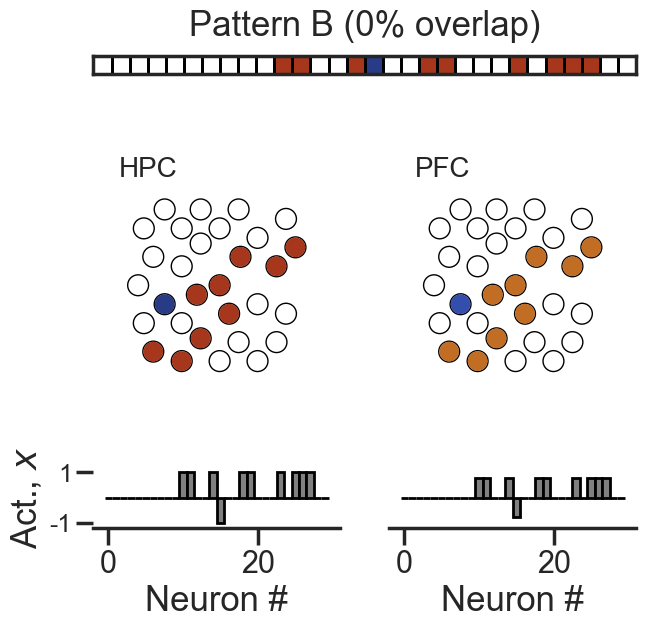

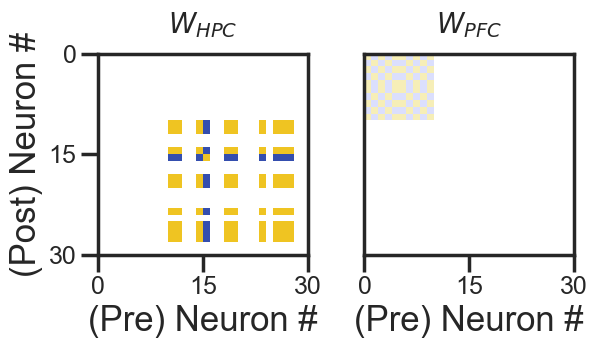

In [8]:
# Figure 2 a)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input('awake1', New_input, 'Pattern B (0% overlap)', n_total, cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', 'awake1', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', 'awake1', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)


# Adjust layout and save the figure
plt.savefig('Figure2_a.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

# Figure 1 b)
fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure2_b.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


#### (Novel) Pattern B - Sleeping stage

0


C:\Users\iguerrei\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)
C:\Users\iguerrei\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


1
2
3
4
5
6


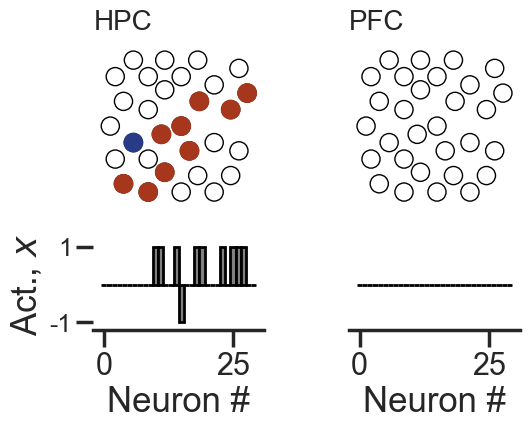

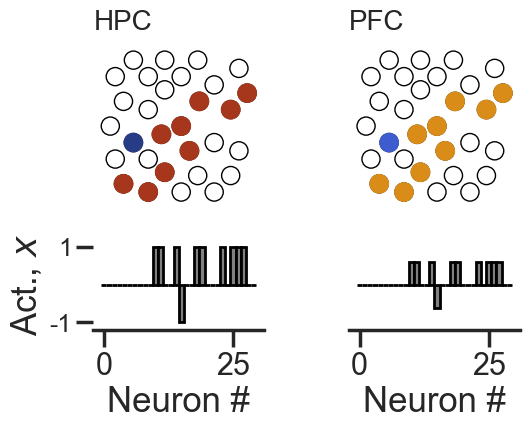

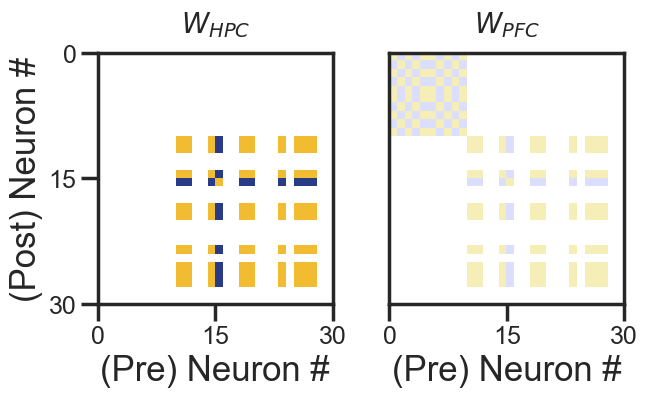

In [9]:
#r =  np.random.normal(loc=0, scale=0.2, size=n_total)
v1 = [i for i in range(n_HPC, n_total)]
v2 = [i for i in range(0, n_HPC)]
weights[v2,v1]=0 # HPC projects to PFC with one-to-one connections. it works if it is -1 too.

for j in range(7):

    print(j)

    r =  np.random.normal(loc=0, scale=0.1, size=n_total)

    
    r_total = []

    i=0

    while True:  
    
    # in a first sleep phase, the HPC and PFC are uncoupled. 
    # During this phase, the HPC, starting from a noisy state, converges to its attractor and replays activity experienced during awake.
    # When it reaches the attractor state, the activity of the network is high (in particular of the engram cells)
    # at this stage, we couple the 2 regions (unidirectionally). 
    # adding inhibitory connections from PFC is not necessary but then won't change the result either. 
        if j==0:
            if i==9000:
                r_HPC = r[:n_HPC].reshape(1,n_HPC)
                r_PFC = r[n_HPC:].reshape(1,n_HPC)
        
                # Figure 1 c1)
                fig = plt.figure(figsize=(5.5, 5))
                grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

                ax_rnn_hpc = fig.add_subplot(grid[0, 0])
                plot_RNN('HPC', 'sleep1_phase1', neuron_positions, r_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

                ax_rnn_pfc = fig.add_subplot(grid[0, 1])
                plot_RNN('PFC', 'sleep1_phase1', neuron_positions, r_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

                # Bar graph with states for HPC
                ax_bar_hpc = fig.add_subplot(grid[1, 0])
                bar_activity(x,r_HPC, ax=ax_bar_hpc, ylabel=True)

                # Bar graph with states for PFC
                ax_bar_pfc = fig.add_subplot(grid[1, 1])
                bar_activity(x,r_PFC, ax=ax_bar_pfc, ylabel=False)

                # Adjust layout and save the figure
                plt.savefig('Figure2_b2_endREM.png', dpi=600, transparent=True, bbox_inches='tight') 
                
                
            if i==9900:
                r_HPC = r[:n_HPC].reshape(1,n_HPC)
                r_PFC = r[n_HPC:].reshape(1,n_HPC)
        
                # Figure 1 c1)
                fig = plt.figure(figsize=(5.5, 5))
                grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

                ax_rnn_hpc = fig.add_subplot(grid[0, 0])
                plot_RNN('HPC', 'sleep1_phase1', neuron_positions, r_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

                ax_rnn_pfc = fig.add_subplot(grid[0, 1])
                plot_RNN('PFC', 'sleep1_phase1', neuron_positions, r_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

                # Bar graph with states for HPC
                ax_bar_hpc = fig.add_subplot(grid[1, 0])
                bar_activity(x,r_HPC, ax=ax_bar_hpc, ylabel=True)

                # Bar graph with states for PFC
                ax_bar_pfc = fig.add_subplot(grid[1, 1])
                bar_activity(x,r_PFC, ax=ax_bar_pfc, ylabel=False)

                # Adjust layout and save the figure
                plt.savefig('Figure2_b2_endNREM.png', dpi=600, transparent=True, bbox_inches='tight') 
    
        if i>9000:
            weights[v1,v2]=1
            weights[v2,v1]=-1
        else:
            weights[v1,v2]=0
            weights[v2,v1]=0
    
    
        weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC) 
        weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)
    
        r_new = r + dt*hopfield(r, weights, 0, n_HPC)
    
        r_total.append(r)
    

        if i>9900: # from 3100 
            #print(r_new)
            break
        
        i+=1
        r = r_new
    
r_total = list(zip(*r_total))

#trained_weights_sleep1 = np.copy(weights)

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


# Plots 
# Figure 2 b1)
#fig = plt.figure(figsize=(7, 5))
#grid = plt.GridSpec(2, 2, hspace=0.5,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

#ax_rnn_hpc = fig.add_subplot(grid[0, 0])
#plot_RNN('HPC', 'sleep1_phase2', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

#ax_rnn_pfc = fig.add_subplot(grid[0, 1])
#plot_RNN('PFC', 'sleep1_phase2', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
#ax_bar_hpc = fig.add_subplot(grid[1, 0])
#bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)

# Bar graph with states for PFC
#ax_bar_pfc = fig.add_subplot(grid[1, 1])
#bar_activity(x,r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
#plt.savefig('Figure2_b1.png', dpi=600, transparent=True,  bbox_inches='tight')
#plt.show


# Figure 2 b2)
fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure2_b2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()



#PFC_trained_weights_sleep1 = np.copy(weights[n_HPC:,n_HPC:])

### Familiar pattern is quickly stored during wakefulness (Figure 3)

#### (Familiar) pattern B - Awake stage


In [10]:
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights
print(weights[n_HPC:,n_HPC:])
weights[v2,v1]=-1
weights[v1,v2]=0.5

r =  np.zeros(n_total)
r_total = []


#I = get_overlap_array(pattern, 0.9)
#print(I)
I = np.array([-1,  1, -1,  1, -1, -1,  0, -1,  1, -1,  0,  0,  0,  0,  0,  0, -1,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
New_input = I.reshape(1,n_HPC)
I=np.concatenate((I,I))

i=0

while True: 
    

    weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
    weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

    r_new = r + dt*hopfield(r, weights, I, n_HPC)
    
    r_total.append(r)
    
    if i>7600:
        print(r_new)
        print(weights[n_HPC:,n_HPC:])
        break
        
    i+=1
    r = r_new
    
r_total = list(zip(*r_total))


r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


[[ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.11287484  0.10166074 -0.11287484  0.10166074 -0.11287484 -0.11287484
   0.10166074 -0.11287484  0.10166074 -0.11287484  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.     

[-0.12889097  0.1169049  -0.12889097  0.1169049  -0.12889097 -0.12889097
 -0.33499174 -0.12889097  0.1169049  -0.12889097  0.          0.
  0.          0.          0.          0.         -0.29856744  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.87420135  0.88640022 -0.87420135  0.88640022 -0.87420135 -0.87420135
  0.3491123  -0.87420135  0.88640022 -0.87420135  0.          0.
  0.          0.          0.          0.         -0.70621387  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[[ 0.18323307 -0.22591207  0.18323307 -0.22591207  0.18323307  0.18323307
  -0.11287484  0.18323307 -0.22591207  0.18323307  0.          0.
   0.          0.          0.          0.          0.07132635  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

C:\Users\iguerrei\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


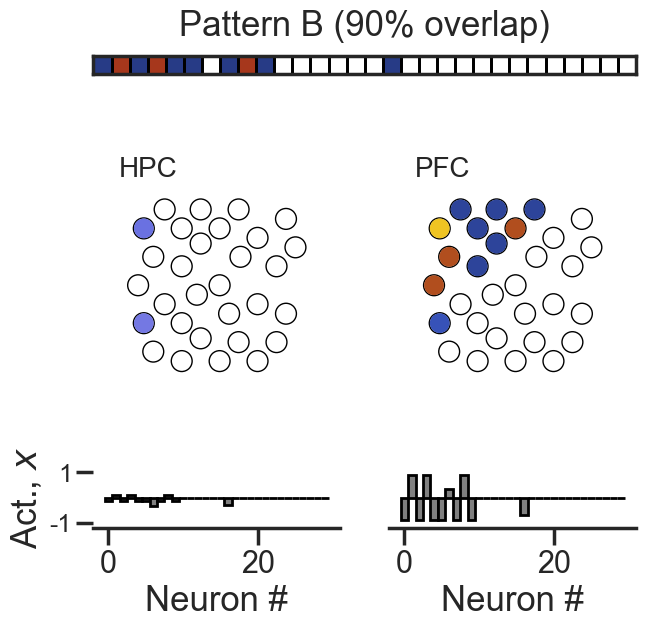

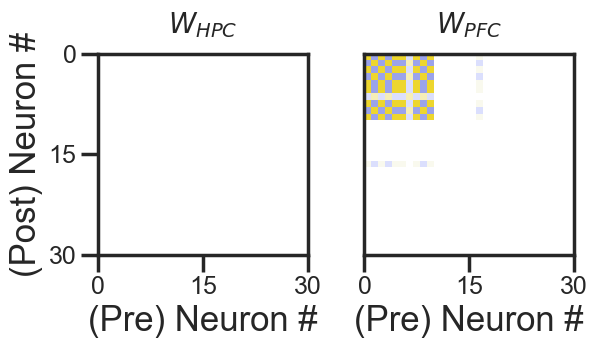

In [11]:
# Figure 3 a)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input('awake1', New_input, 'Pattern B (90% overlap)', n_total, cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', 'awake1', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', 'awake1', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
plt.savefig('Figure3_a1.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

# Figure 3 b)
fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure3_a2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

#### (Familiar) pattern B - Sleeping stage

0


C:\Users\iguerrei\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)
C:\Users\iguerrei\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


1
2
3
4
5
6


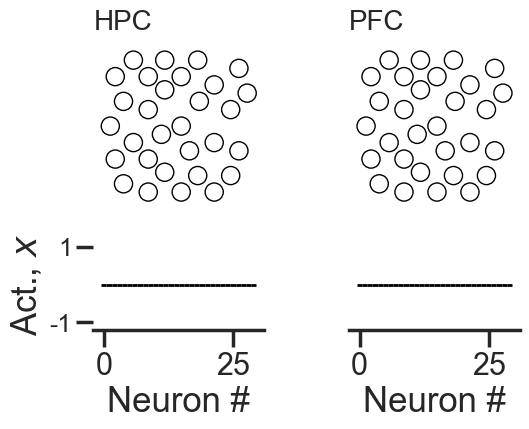

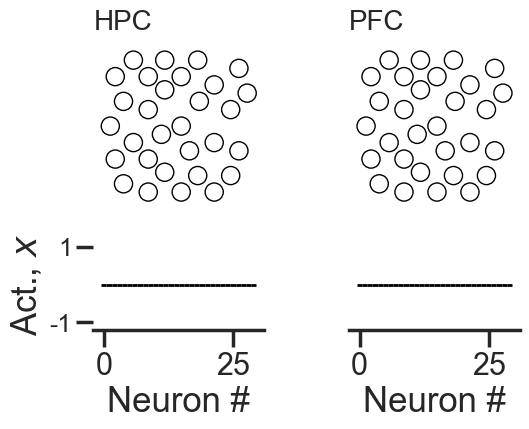

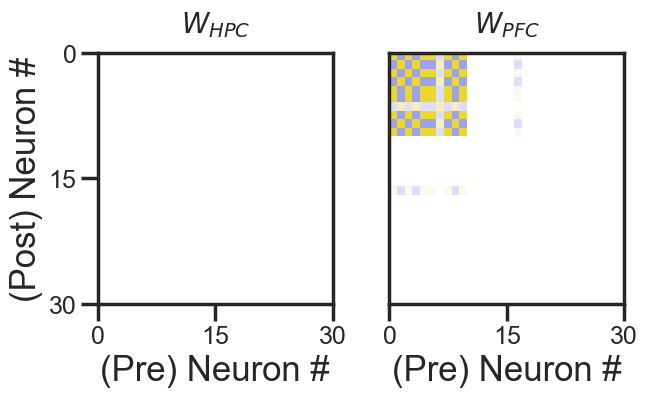

In [12]:
v1 = [i for i in range(n_HPC, n_total)]
v2 = [i for i in range(0, n_HPC)]
weights[v2,v1]=0 # HPC projects to PFC with one-to-one connections. it works if it is -1 too.

for j in range(7):

    print(j)

    r =  np.random.normal(loc=0, scale=0.1, size=n_total)
   
    r_total = []

    i=0

    while True:  
    
    # in a first sleep phase, the HPC and PFC are uncoupled. 
    # During this phase, the HPC, starting from a noisy state, converges to its attractor and replays activity experienced during awake.
    # When it reaches the attractor state, the activity of the network is high (in particular of the engram cells)
    # at this stage, we couple the 2 regions (unidirectionally). 
    # adding inhibitory connections from PFC is not necessary but then won't change the result either. 
        if j==0:
            if i==9000:
                r_HPC = r[:n_HPC].reshape(1,n_HPC)
                r_PFC = r[n_HPC:].reshape(1,n_HPC)
        
                # Figure 1 c1)
                fig = plt.figure(figsize=(5.5, 5))
                grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

                ax_rnn_hpc = fig.add_subplot(grid[0, 0])
                plot_RNN('HPC', 'sleep1_phase1', neuron_positions, r_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

                ax_rnn_pfc = fig.add_subplot(grid[0, 1])
                plot_RNN('PFC', 'sleep1_phase1', neuron_positions, r_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

                # Bar graph with states for HPC
                ax_bar_hpc = fig.add_subplot(grid[1, 0])
                bar_activity(x,r_HPC, ax=ax_bar_hpc, ylabel=True)

                # Bar graph with states for PFC
                ax_bar_pfc = fig.add_subplot(grid[1, 1])
                bar_activity(x,r_PFC, ax=ax_bar_pfc, ylabel=False)

                # Adjust layout and save the figure
                plt.savefig('Figure3_b1_endREM.png', dpi=600, transparent=True, bbox_inches='tight') 
                
                
            if i==9900:
                r_HPC = r[:n_HPC].reshape(1,n_HPC)
                r_PFC = r[n_HPC:].reshape(1,n_HPC)
        
                # Figure 1 c1)
                fig = plt.figure(figsize=(5.5, 5))
                grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

                ax_rnn_hpc = fig.add_subplot(grid[0, 0])
                plot_RNN('HPC', 'sleep1_phase1', neuron_positions, r_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

                ax_rnn_pfc = fig.add_subplot(grid[0, 1])
                plot_RNN('PFC', 'sleep1_phase1', neuron_positions, r_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

                # Bar graph with states for HPC
                ax_bar_hpc = fig.add_subplot(grid[1, 0])
                bar_activity(x,r_HPC, ax=ax_bar_hpc, ylabel=True)

                # Bar graph with states for PFC
                ax_bar_pfc = fig.add_subplot(grid[1, 1])
                bar_activity(x,r_PFC, ax=ax_bar_pfc, ylabel=False)

                # Adjust layout and save the figure
                plt.savefig('Figure3_b1_endNREM.png', dpi=600, transparent=True, bbox_inches='tight') 
    
        if i>9000:
            weights[v1,v2]=1
            weights[v2,v1]=-1
        else:
            weights[v1,v2]=0
            weights[v2,v1]=0
    
    
        weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC) 
        weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)
    
        r_new = r + dt*hopfield(r, weights, 0, n_HPC)
    
        r_total.append(r)
    

        if i>9900: # from 3100 
            #print(r_new)
            break
        
        i+=1
        r = r_new
    
r_total = list(zip(*r_total))

#trained_weights_sleep1 = np.copy(weights)

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


# Plots 
# Figure 2 b1)
#fig = plt.figure(figsize=(7, 5))
#grid = plt.GridSpec(2, 2, hspace=0.5,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

#ax_rnn_hpc = fig.add_subplot(grid[0, 0])
#plot_RNN('HPC', 'sleep1_phase2', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

#ax_rnn_pfc = fig.add_subplot(grid[0, 1])
#plot_RNN('PFC', 'sleep1_phase2', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
#ax_bar_hpc = fig.add_subplot(grid[1, 0])
#bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)

# Bar graph with states for PFC
#ax_bar_pfc = fig.add_subplot(grid[1, 1])
#bar_activity(x,r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
#plt.savefig('Figure2_b1.png', dpi=600, transparent=True,  bbox_inches='tight')
#plt.show


# Figure 2 b2)
fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure3_b2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


### Differential role for HPC and PFC in the encoding of familiar inputs (Figure 4)

#### No HPC-to-PFC excitation

In [13]:
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights
print(weights[n_HPC:,n_HPC:])
weights[v2,v1]=-1
weights[v1,v2]=0.0

r =  np.zeros(n_total)
r_total = []


#I = get_overlap_array(pattern, 0.9)
#print(I)
I = np.array([-1,  1, -1,  1, -1, -1,  0, -1,  1, -1,  0,  0,  0,  0,  0,  0, -1,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
New_input = I.reshape(1,n_HPC)
I=np.concatenate((I,I))

i=0

while True: 
    

    weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
    weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

    r_new = r + dt*hopfield(r, weights, I, n_HPC)
    
    r_total.append(r)
    
    if i>7600:
        print(r_new)
        print(weights[n_HPC:,n_HPC:])
        break
        
    i+=1
    r = r_new
    
r_total = list(zip(*r_total))


r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


[[ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.11287484  0.10166074 -0.11287484  0.10166074 -0.11287484 -0.11287484
   0.10166074 -0.11287484  0.10166074 -0.11287484  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.     

[-0.15068006  0.13791455 -0.15068006  0.13791455 -0.15068006 -0.15068006
 -0.43037244 -0.15068006  0.13791455 -0.15068006  0.          0.
  0.          0.          0.          0.         -0.40450323  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.85477403  0.86775649 -0.85477403  0.86775649 -0.85477403 -0.85477403
  0.45248577 -0.85477403  0.86775649 -0.85477403  0.          0.
  0.          0.          0.          0.         -0.63246184  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[[ 0.17671027 -0.21626567  0.17671027 -0.21626567  0.17671027  0.17671027
  -0.12507268  0.17671027 -0.21626567  0.17671027  0.          0.
   0.          0.          0.          0.          0.05938581  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

C:\Users\iguerrei\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


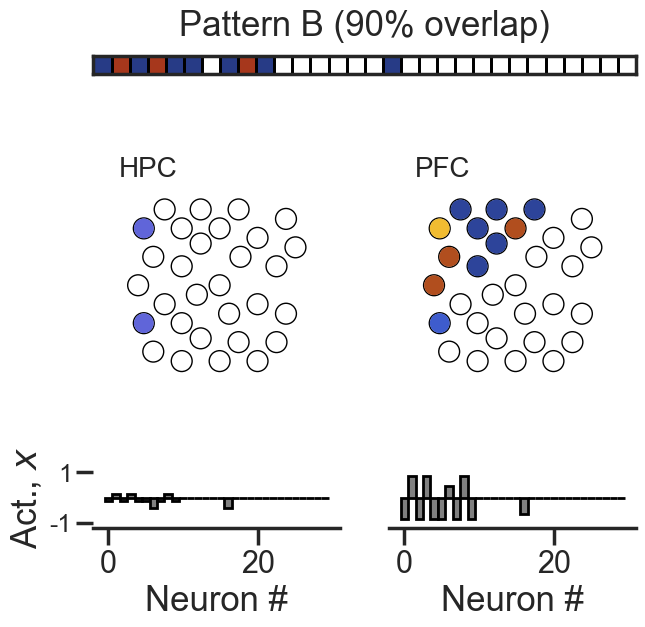

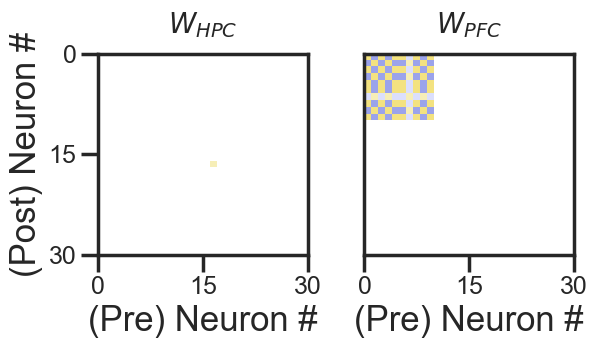

In [14]:
# Figure 4 a1)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input('awake1', New_input, 'Pattern B (90% overlap)', n_total, cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', 'awake1', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', 'awake1', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)


# Adjust layout and save the figure
plt.savefig('Figure4_a1.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

# Figure 4 a2)
fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure4_a2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

#### No PFC-to-HPC inhibition 

In [15]:
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights
print(weights[n_HPC:,n_HPC:])
weights[v2,v1]=0
weights[v1,v2]=0.5

r =  np.zeros(n_total)
r_total = []


#I = get_overlap_array(pattern, 0.9)
#print(I)
I = np.array([-1,  1, -1,  1, -1, -1,  0, -1,  1, -1,  0,  0,  0,  0,  0,  0, -1,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
New_input = I.reshape(1,n_HPC)
I=np.concatenate((I,I))

i=0

while True: 
    

    weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
    weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

    r_new = r + dt*hopfield(r, weights, I, n_HPC)
    
    r_total.append(r)
    
    if i>7600:
        print(r_new)
        print(weights[n_HPC:,n_HPC:])
        break
        
    i+=1
    r = r_new
    
r_total = list(zip(*r_total))


r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


[[ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.11287484  0.10166074 -0.11287484  0.10166074 -0.11287484 -0.11287484
   0.10166074 -0.11287484  0.10166074 -0.11287484  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.     

[-0.99999673  0.99999995 -0.99999673  0.99999995 -0.99999673 -0.99999673
  0.         -0.99999673  0.99999995 -0.99999673  0.          0.
  0.          0.          0.          0.         -0.99999673  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.94247193  0.9495468  -0.94247193  0.9495468  -0.94247193 -0.94247193
  0.66708684 -0.94247193  0.9495468  -0.94247193  0.          0.
  0.          0.          0.          0.         -0.83119301  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[[ 0.19933844 -0.25029875  0.19933844 -0.25029875  0.19933844  0.19933844
  -0.18486624  0.19933844 -0.25029875  0.19933844  0.          0.
   0.          0.          0.          0.          0.09092888  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

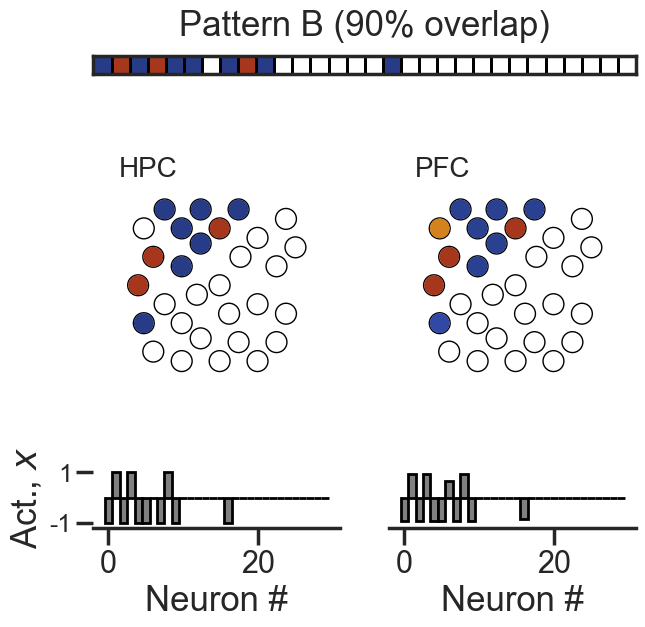

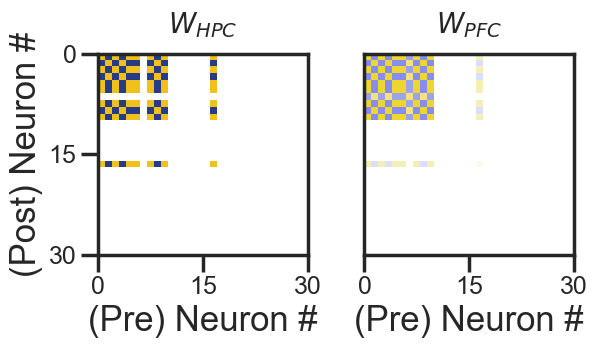

In [16]:
# Figure 4 b1)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input('awake1', New_input, 'Pattern B (90% overlap)', n_total, cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', 'awake1', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', 'awake1', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)


# Adjust layout and save the figure
plt.savefig('Figure4_b1.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

# Figure 4 b2)
fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure4_b2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

### Generalization of results - examining changes in PFC plasticity and network activity (Figure 5)

#### Create a bunch of different patterns for each degree of overlap

In [17]:
degree_of_overlap = np.around(np.arange(0, 1, 0.1), decimals=1)
new_memories = {}

p = 10  # Number of new inputs to generate

for o in degree_of_overlap:
    inputs = []
    for _ in range(p):
        I = get_overlap_array(pattern, o)  # Generate new input
        inputs.append(I)  # Store new input in the list
    new_memories[o] = inputs  # Store the list of inputs associated with 'o'

    
print("First input with 0.1 overlap:", new_memories[0.1][0])    

First input with 0.1 overlap: [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  1.  0.  1.  1.  1.  0.
  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.]


#### Examining sparseness

0.0
[10 12 15 18 19 20 21 27 28 29]
[10 11 13 14 21 22 24 26 27 29]
[10 15 16 18 19 21 24 26 27 29]
[10 11 15 16 17 19 20 26 27 29]
[13 14 15 16 18 19 20 24 25 28]
[10 11 14 16 17 18 22 27 28 29]
[10 11 13 19 22 25 26 27 28 29]
[10 12 16 21 22 23 25 26 27 29]
[10 11 12 15 17 19 22 25 26 27]
[11 13 15 16 18 19 21 23 26 29]
0.1
[ 5 10 12 14 15 16 18 24 26 28]
[ 0 12 14 16 18 19 21 22 23 29]
[ 2 11 14 15 16 18 20 22 24 27]
[ 6 11 12 17 21 23 24 27 28 29]
[ 9 11 12 17 18 20 24 25 26 29]
[ 9 10 12 13 17 18 21 25 26 28]
[ 2 11 13 14 16 18 22 23 26 27]
[ 8 10 11 12 15 21 22 26 27 28]
[ 7 10 13 14 19 21 26 27 28 29]
[ 7 10 11 13 14 15 16 19 22 28]
0.2
[ 4  9 17 18 20 22 23 26 27 28]
[ 6  8 12 13 16 17 18 19 22 27]
[ 7  9 10 11 18 22 24 27 28 29]
[ 1  9 10 12 14 16 18 20 21 23]
[ 7  8 11 17 18 21 22 24 28 29]
[ 2  8 15 16 18 20 23 25 27 28]
[ 3  4 10 13 15 18 22 23 24 29]
[ 2  9 10 14 15 18 20 22 23 28]
[ 2  8 11 12 14 16 18 23 25 29]
[ 2  7 11 12 14 16 17 26 27 29]
0.3
[ 4  5  7 10 11 18 22 24

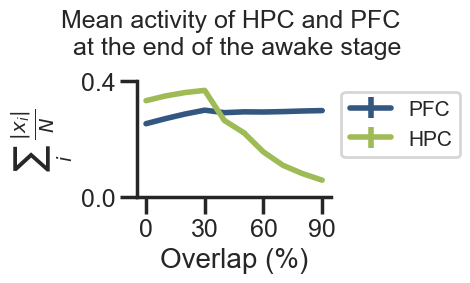

In [22]:
import numpy as np
import matplotlib.pyplot as plt

sparse_HPC = np.zeros(len(degree_of_overlap))
sparse_PFC = np.zeros(len(degree_of_overlap))

std_HPC = np.zeros(len(degree_of_overlap))
std_PFC = np.zeros(len(degree_of_overlap))

all_mean_deltaW = np.zeros(len(degree_of_overlap))
deltaW_PFC = np.zeros(len(degree_of_overlap))


for n,o in enumerate(degree_of_overlap):
    print(o)
    patterns = new_memories[o] # get all patterns for degree of overlap 'o'
    
    fr_HPC=[]
    fr_PFC=[]
    
    for p in range(len(patterns)):
        
        weights = np.zeros((n_total, n_total))
        weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights, with memory_A
        weights[v2,v1]=-1 # Inhibitory PFC-to-HPC
        weights[v1,v2]=0.5 # Excitatory HPC-to-PFC
    
        r =  np.zeros(n_total)

        I = patterns[p]
        targeted_neurons = np.nonzero(I)[0]
        print(targeted_neurons)
        I=np.concatenate((I,I))

        i=0

        while True: 

            weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
            weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

            r_new = r + dt*hopfield(r, weights, I, n_HPC)

            if i>7600:
                abs_fr = np.abs(r)
                fr_HPC.append(np.mean(abs_fr[:n_HPC]))
                fr_PFC.append(np.mean(abs_fr[n_HPC:]))
                

                # Calculate the absolute difference between corresponding entries
         #       abs_changes_PFC = np.abs(PFC_trained_weights_sleep1 - weights[n_HPC:,n_HPC:])

                # Calculate the average of the absolute differences
         #       mean_changes_PFC_plasticity = np.mean(abs_changes_PFC)
         #       deltaW_PFC[n] = mean_changes_PFC_plasticity
            
                break
        
            i+=1
            r = r_new
            
    sparse_HPC[n]=np.mean(fr_HPC)
    std_HPC[n]=np.std(fr_HPC)
    sparse_PFC[n]=np.mean(fr_PFC)
    std_PFC[n]=np.std(fr_PFC)
        
        
        
from scipy.stats import gaussian_kde

params = {
   'axes.labelsize': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18,
    'lines.linewidth': 2,
   'figure.figsize': [3, 3]
   }

plt.rcParams.update(params)

# density plot
import seaborn as sns

plt.figure(figsize=(2.5,1.5))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.errorbar(degree_of_overlap*100,sparse_PFC, yerr=std_PFC, color='#335781', linewidth=4, label='PFC')
plt.errorbar(degree_of_overlap*100,sparse_HPC, yerr=std_HPC, color='#9FBB55', linewidth=4, label='HPC')
plt.xticks([0,30,60,90])
plt.yticks([0,0.4])
plt.legend(bbox_to_anchor=(1, 1), fontsize=15)
plt.ylabel(r'$\sum_i$ $\frac{|x_i|}{N}$', fontsize=20)
plt.xlabel('Overlap (%)')
plt.title('Mean activity of HPC and PFC \n at the end of the awake stage', pad=20, fontsize=18)
plt.savefig('Sparssity_index.png', bbox_inches='tight', dpi=600, transparent=True)


import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

#plt.figure(figsize=(3, 2))
#plt.gca().spines['top'].set_visible(False)
#plt.gca().spines['right'].set_visible(False)
#plt.errorbar(degree_of_overlap * 100, mean_deltaW, yerr=std_deltaW, color='#335781', linewidth=4)
#plt.plot(degree_of_overlap * 100, mean_deltaW, color='#335781', linewidth=4)
#plt.xticks([0, 30, 60, 90])

# Format y-axis ticks in scientific notation
#formatter = ScalarFormatter(useMathText=True)
#formatter.set_powerlimits((-2, 2))  # Set the power limits for scientific notation
#plt.gca().yaxis.set_major_formatter(formatter)

#plt.ylabel(r'$<|\Delta W_{ij}|_{PFC}>$', fontsize=20)
#plt.xlabel('Overlap (%)')
#plt.savefig('Changes_PFCconnectivity.png', bbox_inches='tight', dpi=600, transparent=True)
#plt.show()



#### Examining PFC connectivity changes

0.0
[10 12 15 18 19 20 21 27 28 29]
[10 11 13 14 21 22 24 26 27 29]
[10 15 16 18 19 21 24 26 27 29]
[10 11 15 16 17 19 20 26 27 29]
[13 14 15 16 18 19 20 24 25 28]
[10 11 14 16 17 18 22 27 28 29]
[10 11 13 19 22 25 26 27 28 29]
[10 12 16 21 22 23 25 26 27 29]
[10 11 12 15 17 19 22 25 26 27]
[11 13 15 16 18 19 21 23 26 29]
0.1
[ 5 10 12 14 15 16 18 24 26 28]
[ 0 12 14 16 18 19 21 22 23 29]
[ 2 11 14 15 16 18 20 22 24 27]
[ 6 11 12 17 21 23 24 27 28 29]
[ 9 11 12 17 18 20 24 25 26 29]
[ 9 10 12 13 17 18 21 25 26 28]
[ 2 11 13 14 16 18 22 23 26 27]
[ 8 10 11 12 15 21 22 26 27 28]
[ 7 10 13 14 19 21 26 27 28 29]
[ 7 10 11 13 14 15 16 19 22 28]
0.2
[ 4  9 17 18 20 22 23 26 27 28]
[ 6  8 12 13 16 17 18 19 22 27]
[ 7  9 10 11 18 22 24 27 28 29]
[ 1  9 10 12 14 16 18 20 21 23]
[ 7  8 11 17 18 21 22 24 28 29]
[ 2  8 15 16 18 20 23 25 27 28]
[ 3  4 10 13 15 18 22 23 24 29]
[ 2  9 10 14 15 18 20 22 23 28]
[ 2  8 11 12 14 16 18 23 25 29]
[ 2  7 11 12 14 16 17 26 27 29]
0.3
[ 4  5  7 10 11 18 22 24

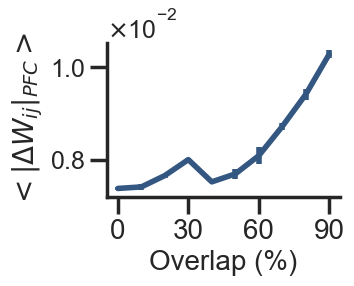

In [19]:
import numpy as np
import matplotlib.pyplot as plt

mean_deltaW = np.zeros(len(degree_of_overlap))
std_deltaW = np.zeros(len(degree_of_overlap))

for n,o in enumerate(degree_of_overlap):
    print(o)
    patterns = new_memories[o] # get all patterns for degree of overlap 'o'
    
    mean_deltaW_PFC=[]
    
    for p in range(len(patterns)):
        
        weights = np.zeros((n_total, n_total))
        weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights, with memory_A
        weights[v2,v1]=-1 # Inhibitory PFC-to-HPC
        weights[v1,v2]=0.5 # Excitatory HPC-to-PFC
    
        r =  np.zeros(n_total)

        I = patterns[p]
        targeted_neurons = np.nonzero(I)[0]
        print(targeted_neurons)
        I=np.concatenate((I,I))

        i=0

        while True: 

            weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
            weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

            r_new = r + dt*hopfield(r, weights, I, n_HPC)

            if i>7600:
                abs_deltaW_PFC = np.abs(PFC_trained_weights_sleep1 - weights[n_HPC:,n_HPC:])
                mean_deltaW_PFC.append(np.mean(abs_deltaW_PFC)) # mean over full connectivity for 1 simulation 

                break
        
            i+=1
            r = r_new
            
    mean_deltaW[n]=np.mean(mean_deltaW_PFC) # mean over 10 simulations for a degree of overlap 'o'
    std_deltaW[n]=np.std(mean_deltaW_PFC)        
        
        
from scipy.stats import gaussian_kde

params = {
   'axes.labelsize': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 18,
    'lines.linewidth': 2,
   'figure.figsize': [3, 3]
   }

plt.rcParams.update(params)

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(3, 2))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.errorbar(degree_of_overlap * 100, mean_deltaW, yerr=std_deltaW, color='#335781', linewidth=4)
#plt.plot(degree_of_overlap * 100, mean_deltaW, color='#335781', linewidth=4)
plt.xticks([0, 30, 60, 90])

# Format y-axis ticks in scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Set the power limits for scientific notation
plt.gca().yaxis.set_major_formatter(formatter)

plt.ylabel(r'$<|\Delta W_{ij}|_{PFC}>$', fontsize=20)
plt.xlabel('Overlap (%)')
plt.savefig('Changes_PFCconnectivity.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()
